In [10]:
import pandas as pd

df = pd.read_csv("Task 3 and 4_Loan_Data.csv")

df = df[df["fico_score"].between(300, 850)].copy()
df["default"] = df["default"].astype(int)

display(df.head())
df.info()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [11]:
import numpy as np
from sklearn.cluster import KMeans

fico_values = df[["fico_score"]].values

N_CLUSTERS = 10
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10) # n_init=10 to suppress warning

df["fico_cluster"] = kmeans.fit_predict(fico_values)

cluster_centers = sorted(kmeans.cluster_centers_.flatten())

original_cluster_indices_order = np.argsort(kmeans.cluster_centers_.flatten())
cluster_order = {original_index: new_order for new_order, original_index in enumerate(original_cluster_indices_order)}

df["fico_bucket"] = df["fico_cluster"].map(cluster_order) + 1

display(df[['fico_score', 'fico_cluster', 'fico_bucket']].head())


,fico_score,fico_cluster,fico_bucket
0,605,2,4
1,572,6,3
2,602,2,4
3,612,8,5
4,631,8,5


In [12]:
#probability of default table
pd_table = (
    df.groupby("fico_bucket")["default"]
    .mean()
    .reset_index()
    .rename(columns={"default": "PD"})
)

pd_table["PD (%)"] = (pd_table["PD"] * 100).round(2)

bucket_ranges = []
for i in range(1, N_CLUSTERS + 1):
    subset = df[df["fico_bucket"] == i]["fico_score"]
    bucket_ranges.append(f"{subset.min():.0f} – {subset.max():.0f}")

pd_table["FICO Range"] = bucket_ranges
pd_table = pd_table[["fico_bucket", "FICO Range", "PD (%)"]].rename(columns={"fico_bucket": "Bucket"})

kmeans_ranges = pd_table['FICO Range'].tolist()
kmeans_initial_boundaries = sorted(list(set([int(r.split('–')[0].strip()) for r in kmeans_ranges])))

if kmeans_initial_boundaries[-1] < 850:
     kmeans_initial_boundaries.append(850)

if kmeans_initial_boundaries[0] > 300:
    kmeans_initial_boundaries.insert(0, 300)

print("\n initial bucket boundaries derived from K-Means for DP initialization:")
print(kmeans_initial_boundaries)



 initial bucket boundaries derived from K-Means for DP initialization:
[300, 408, 513, 553, 585, 612, 637, 661, 686, 716, 756, 850]


In [13]:
dp_bucket_boundaries_combined = kmeans_initial_boundaries
print(dp_bucket_boundaries_combined)

def assign_combined_dp_bucket(fico_score, boundaries):
    for i in range(len(boundaries) - 1):
        if i < len(boundaries) - 2:
             if fico_score >= boundaries[i] and fico_score < boundaries[i+1]:
                 return i + 1 # return 1-based bucket index
        else: # last bucket is inclusive of both ends
             if fico_score >= boundaries[i] and fico_score <= boundaries[i+1]:
                 return i + 1 # return 1-based bucket index
    return None

df['fico_combined_dp_bucket'] = df['fico_score'].apply(lambda x: assign_combined_dp_bucket(x, dp_bucket_boundaries_combined))

observed_pd_combined_dp = df.groupby("fico_combined_dp_bucket")["default"].agg(['sum', 'count']).reset_index()
observed_pd_combined_dp = observed_pd_combined_dp.rename(columns={'sum': 'defaults', 'count': 'total'})
observed_pd_combined_dp['PD'] = observed_pd_combined_dp['defaults'] / observed_pd_combined_dp['total']

all_expected_buckets = range(1, len(dp_bucket_boundaries_combined))
pd_table_combined_dp = pd.DataFrame({'fico_combined_dp_bucket': all_expected_buckets})

pd_table_combined_dp = pd.merge(pd_table_combined_dp, observed_pd_combined_dp, on='fico_combined_dp_bucket', how='left')

pd_table_combined_dp['PD'] = pd_table_combined_dp['PD'].fillna(0)
pd_table_combined_dp['defaults'] = pd_table_combined_dp['defaults'].fillna(0).astype(int)
pd_table_combined_dp['total'] = pd_table_combined_dp['total'].fillna(0).astype(int)
pd_table_combined_dp["PD (%)"] = (pd_table_combined_dp["PD"] * 100).round(2)

combined_dp_bucket_labels = []
for i in range(len(dp_bucket_boundaries_combined) - 1):
    lower_bound = dp_bucket_boundaries_combined[i]
    upper_bound = dp_bucket_boundaries_combined[i+1]
    if i < len(dp_bucket_boundaries_combined) - 2:
        combined_dp_bucket_labels.append(f"{lower_bound} – {upper_bound - 1}")
    else:
        combined_dp_bucket_labels.append(f"{lower_bound} – {upper_bound}")

pd_table_combined_dp["FICO Range"] = combined_dp_bucket_labels
pd_table_combined_dp = pd_table_combined_dp[["fico_combined_dp_bucket", "FICO Range", "PD (%)"]].rename(columns={"fico_combined_dp_bucket": "Bucket"})

display(pd_table_combined_dp)

[300, 408, 513, 553, 585, 612, 637, 661, 686, 716, 756, 850]


,Bucket,FICO Range,PD (%)
0,1,300 – 407,0.00
1,2,408 – 512,67.51
2,3,513 – 552,47.86
3,4,553 – 584,32.63
4,5,585 – 611,24.02
5,6,612 – 636,16.85
6,7,637 – 660,13.19
7,8,661 – 685,9.51
8,9,686 – 715,7.63
9,10,716 – 755,3.97


In [14]:
observed_pd_combined_dp = df.groupby("fico_combined_dp_bucket")["default"].mean().reset_index()
observed_pd_combined_dp = observed_pd_combined_dp.rename(columns={"default": "Observed_PD"})

pd_table_combined_dp = pd.merge(pd_table_combined_dp, observed_pd_combined_dp, left_on="Bucket", right_on="fico_combined_dp_bucket", how="left")
pd_table_combined_dp = pd_table_combined_dp.drop(columns="fico_combined_dp_bucket")
pd_table_combined_dp['Predicted_PD'] = pd_table_combined_dp['PD (%)'] / 100

# squared error
pd_table_combined_dp['Squared_Error'] = (pd_table_combined_dp['Predicted_PD'] - pd_table_combined_dp['Observed_PD'])**2

#  mean of squared errors
mse_combined_dp = pd_table_combined_dp['Squared_Error'].mean()



bucket_to_predicted_pd_combined_dp = pd_table_combined_dp.set_index('Bucket')['Predicted_PD'].to_dict()
df['predicted_pd_combined_dp'] = df['fico_combined_dp_bucket'].map(bucket_to_predicted_pd_combined_dp)
#  log-likelihood for each data point
df['log_likelihood_combined_dp'] = df.apply(lambda row: log_likelihood(1, row['default']) if row['predicted_pd_combined_dp'] in [0, 1] else (row['default'] * np.log(row['predicted_pd_combined_dp']) + (1 - row['default']) * np.log(1 - row['predicted_pd_combined_dp'])), axis=1)

# sum the log-likelihoods for the total log-likelihood
total_log_likelihood_combined_dp = df['log_likelihood_combined_dp'].sum()

print(f"Mean Squared Error (MSE): {mse_combined_dp:.6f}")
print(f"Total Log-Likelihood: {total_log_likelihood_combined_dp:.6f}")

Mean Squared Error (MSE): 0.000000
Total Log-Likelihood: -4232.216146


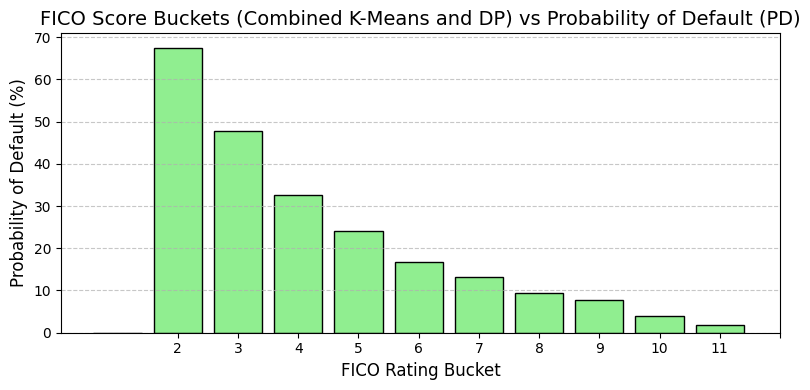

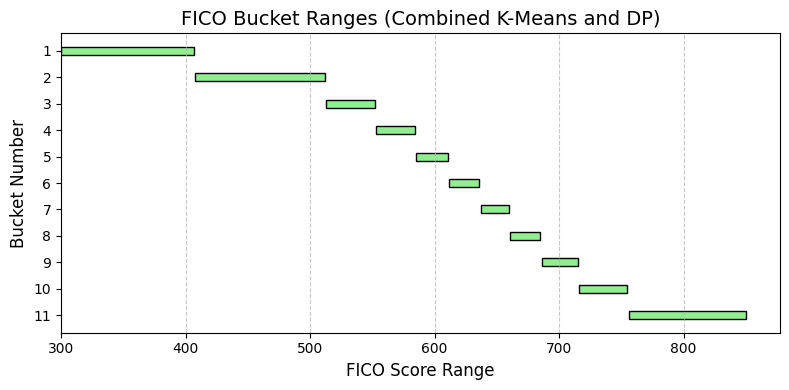

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.bar(pd_table_combined_dp["Bucket"].astype(str), pd_table_combined_dp["PD (%)"], color="lightgreen", edgecolor="black")
plt.title("FICO Score Buckets (Combined K-Means and DP) vs Probability of Default (PD)", fontsize=14)
plt.xlabel("FICO Rating Bucket", fontsize=12)
plt.ylabel("Probability of Default (%)", fontsize=12)
plt.xticks(pd_table_combined_dp["Bucket"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8, 4))
bar_height = 0.3
def extract_range_bounds(pd_table):
    bounds = []
    for fico_range in pd_table['FICO Range']:
        lower, upper = map(int, fico_range.replace('–', '-').split('-'))
        bounds.append((lower, upper))
    return bounds
combined_dp_bounds = extract_range_bounds(pd_table_combined_dp)
for i, (lower, upper) in enumerate(combined_dp_bounds):
    bucket_num = pd_table_combined_dp['Bucket'].iloc[i]
    ax.barh(y=bucket_num, width=upper - lower, left=lower, height=bar_height, color='lightgreen', edgecolor='black', label='Combined K-Means and DP')

ax.set_xlabel("FICO Score Range", fontsize=12)
ax.set_ylabel("Bucket Number", fontsize=12)
ax.set_title("FICO Bucket Ranges (Combined K-Means and DP)", fontsize=14)
ax.invert_yaxis() # invert y-axis so bucket 1 is at the top
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_yticks(pd_table_combined_dp['Bucket'])
plt.tight_layout()
plt.show()